In [6]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import time
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import tensorflow
import socket

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time
from matplotlib import image
from torchvision import transforms, datasets, models
from torchensemble import BaggingClassifier, VotingClassifier
from torchensemble.utils.logging import set_logger

# Set path

In [7]:
### Configurations
data_dir = 'input/data/train'
test_dir = '/opt/ml/input/data/eval'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/csvs/new_train.csv'
model_dir = f'{data_dir}/models'

In [8]:
df = pd.read_csv(df_path)
df = df.drop(columns=['Class Compare', 'Original Class', '-.1', '-', 'Mask', 'Gender', 'Age', '-.2', 'Gender.1', 'Age.1', 'ID'])
df.head()

Full Path  NewClass  \
0  /opt/ml/input/data/train/images/000001_female_...        10   
1  /opt/ml/input/data/train/images/000001_female_...         4   
2  /opt/ml/input/data/train/images/000001_female_...         4   
3  /opt/ml/input/data/train/images/000001_female_...         4   
4  /opt/ml/input/data/train/images/000001_female_...         4   

            ImageName  
0  incorrect_mask.jpg  
1           mask1.jpg  
2           mask2.jpg  
3           mask3.jpg  
4           mask4.jpg

# Set logger to see the change

In [4]:
logger = set_logger('ensemble_logger', use_tb_logger=True)

Log will be saved in '/opt/ml/logs'.
Start logging into file /opt/ml/logs/ensemble_logger-2021_08_31_16_52.log...


# Convert to GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
device

device(type='cuda', index=0)

# Call our base model

In [11]:
base_model = models.resnet152(pretrained=True)
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 18)

In [7]:
model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    cuda=True,
)

In [8]:
model.set_optimizer('SGD',
                    momentum=0.9,
                    lr=1e-3,          
                    weight_decay=5e-4) 

model.to(device)

BaggingClassifier(
  (base_estimator_): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequ

# Get train loader

In [9]:
class BaseDataset(data.Dataset):

    def __init__(self, transform=None):
        
        self.X = df['Full Path']
        self.y = df['NewClass']
        self.transform = transform

    def set_transform(self, transform):
        
        self.transform = transform

    def __getitem__(self, index):

        image = Image.open(self.X[index])
        label = self.y[index]
        
        # 이미지를 Augmentation 시킵니다.
        # image_transform = self.transform(image=np.array(image))['image']
        image_transform = self.transform(image)
        return image_transform, label

    def __len__(self):
        return len(self.X)

In [10]:
dataset = BaseDataset()

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

In [11]:
mean = [0.56019068, 0.52409788, 0.50145447]
std = [0.23318342, 0.24299835, 0.24567397]

In [12]:
transforms_train = transforms.Compose([
    transforms.Resize((512, 384)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean, std), # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((512, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset.dataset.set_transform(transforms_train)
val_dataset.dataset.set_transform(transforms_val)

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

In [14]:
model.fit(train_loader=train_loader,
          test_loader=val_loader,
          epochs=4)

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 2.69837 | Correct: 7/19
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 1.33219 | Correct: 11/21
Estimator: 000 | Epoch: 000 | Batch: 200 | Loss: 0.87629 | Correct: 15/20
Estimator: 000 | Epoch: 000 | Batch: 300 | Loss: 0.65122 | Correct: 14/18
Estimator: 000 | Epoch: 000 | Batch: 400 | Loss: 0.60047 | Correct: 16/20
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 2.75104 | Correct: 5/22
Estimator: 001 | Epoch: 000 | Batch: 100 | Loss: 1.32130 | Correct: 12/20
Estimator: 001 | Epoch: 000 | Batch: 200 | Loss: 0.97462 | Correct: 15/19
Estimator: 001 | Epoch: 000 | Batch: 300 | Loss: 0.58732 | Correct: 17/21
Estimator: 001 | Epoch: 000 | Batch: 400 | Loss: 0.62009 | Correct: 16/22
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 2.80521 | Correct: 3/20
Estimator: 002 | Epoch: 000 | Batch: 100 | Loss: 1.79205 | Correct: 7/18
Estimator: 002 | Epoch: 000 | Batch: 200 | Loss: 0.83049 | Correct: 16/20
Estimator: 002 | Epoch: 000 | Batch: 300 |

2021-08-31 17:48:47,861 - INFO: Saving the model to `./BaggingClassifier_ResNet_10_ckpt.pth`
2021-08-31 17:48:53,123 - INFO: Epoch: 000 | Validation Acc: 89.101 % | Historical Best: 89.101 %


Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 0.24398 | Correct: 17/18
Estimator: 000 | Epoch: 001 | Batch: 100 | Loss: 0.58782 | Correct: 17/21
Estimator: 000 | Epoch: 001 | Batch: 200 | Loss: 0.17307 | Correct: 20/20
Estimator: 000 | Epoch: 001 | Batch: 300 | Loss: 0.17638 | Correct: 18/18
Estimator: 000 | Epoch: 001 | Batch: 400 | Loss: 0.14679 | Correct: 16/17
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 0.53644 | Correct: 20/24
Estimator: 001 | Epoch: 001 | Batch: 100 | Loss: 0.35360 | Correct: 15/18
Estimator: 001 | Epoch: 001 | Batch: 200 | Loss: 0.25120 | Correct: 19/20
Estimator: 001 | Epoch: 001 | Batch: 300 | Loss: 0.27889 | Correct: 16/18
Estimator: 001 | Epoch: 001 | Batch: 400 | Loss: 0.41113 | Correct: 16/19
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 0.36103 | Correct: 20/22
Estimator: 002 | Epoch: 001 | Batch: 100 | Loss: 0.42485 | Correct: 18/21
Estimator: 002 | Epoch: 001 | Batch: 200 | Loss: 0.35982 | Correct: 18/20
Estimator: 002 | Epoch: 001 | Batch: 3

2021-08-31 18:43:43,817 - INFO: Saving the model to `./BaggingClassifier_ResNet_10_ckpt.pth`
2021-08-31 18:44:04,439 - INFO: Epoch: 001 | Validation Acc: 95.344 % | Historical Best: 95.344 %


Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 0.26040 | Correct: 16/18
Estimator: 000 | Epoch: 002 | Batch: 100 | Loss: 0.13225 | Correct: 19/20
Estimator: 000 | Epoch: 002 | Batch: 200 | Loss: 0.09151 | Correct: 22/22
Estimator: 000 | Epoch: 002 | Batch: 300 | Loss: 0.10244 | Correct: 17/17
Estimator: 000 | Epoch: 002 | Batch: 400 | Loss: 0.03446 | Correct: 22/22
Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 0.20018 | Correct: 19/20
Estimator: 001 | Epoch: 002 | Batch: 100 | Loss: 0.13198 | Correct: 20/20
Estimator: 001 | Epoch: 002 | Batch: 200 | Loss: 0.26080 | Correct: 19/22
Estimator: 001 | Epoch: 002 | Batch: 300 | Loss: 0.08739 | Correct: 18/19
Estimator: 001 | Epoch: 002 | Batch: 400 | Loss: 0.25603 | Correct: 19/20
Estimator: 002 | Epoch: 002 | Batch: 000 | Loss: 0.12387 | Correct: 21/22
Estimator: 002 | Epoch: 002 | Batch: 100 | Loss: 0.40801 | Correct: 19/23
Estimator: 002 | Epoch: 002 | Batch: 200 | Loss: 0.22696 | Correct: 19/20
Estimator: 002 | Epoch: 002 | Batch: 3

2021-08-31 19:38:56,904 - INFO: Saving the model to `./BaggingClassifier_ResNet_10_ckpt.pth`
2021-08-31 19:39:16,882 - INFO: Epoch: 002 | Validation Acc: 97.778 % | Historical Best: 97.778 %


Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.11275 | Correct: 22/23
Estimator: 000 | Epoch: 003 | Batch: 100 | Loss: 0.21313 | Correct: 20/21
Estimator: 000 | Epoch: 003 | Batch: 200 | Loss: 0.05243 | Correct: 18/18
Estimator: 000 | Epoch: 003 | Batch: 300 | Loss: 0.07838 | Correct: 20/20
Estimator: 000 | Epoch: 003 | Batch: 400 | Loss: 0.03977 | Correct: 20/20
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 0.05572 | Correct: 18/18
Estimator: 001 | Epoch: 003 | Batch: 100 | Loss: 0.06368 | Correct: 20/20
Estimator: 001 | Epoch: 003 | Batch: 200 | Loss: 0.13547 | Correct: 18/19
Estimator: 001 | Epoch: 003 | Batch: 300 | Loss: 0.11242 | Correct: 18/19
Estimator: 001 | Epoch: 003 | Batch: 400 | Loss: 0.29770 | Correct: 20/23
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 0.06256 | Correct: 23/23
Estimator: 002 | Epoch: 003 | Batch: 100 | Loss: 0.11453 | Correct: 24/25
Estimator: 002 | Epoch: 003 | Batch: 200 | Loss: 0.22776 | Correct: 18/19
Estimator: 002 | Epoch: 003 | Batch: 3

2021-08-31 20:34:04,566 - INFO: Saving the model to `./BaggingClassifier_ResNet_10_ckpt.pth`
2021-08-31 20:34:24,687 - INFO: Epoch: 003 | Validation Acc: 98.624 % | Historical Best: 98.624 %


In [1]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir=logs/ --host 0.0.0.0 --port 6006

### save resnet152 model

In [31]:
# torch.save(model.state_dict(), os.path.join(model_dir, 'ensemble_resnet152.pth'))

# Test the model

### load resnet152

In [12]:
from torchensemble.utils import io

new_model = models.resnet152(pretrained=True)
new_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    cuda=True,
)
new_model.set_optimizer('SGD',
                    momentum=0.9,
                    lr=1e-3,          
                    weight_decay=5e-4) 

new_model.to(device)

io.load(new_model, model_dir)  # reload

# resnet152_model = models.resnet152(pretrained=True)
# num_features = resnet152_model.fc.in_features
# resnet152_model.fc = nn.Linear(num_features, 18) # binary classification (num_of_class == 2)
# resnet152_model.load_state_dict(torch.load(resnet152_path))
# resnet152_model.to(device)

In [14]:
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms

In [15]:
mean=(0.5, 0.5, 0.5)
std=(0.2, 0.2, 0.2)

In [16]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
#             tmp_image = np.array(image)
#             image_mean = tmp_image.mean(axis=(0,1)) / 255.
#             image_std = tmp_image.std(axis=(0,1)) / 255.
#             image = self.transform(mean=image_mean, std=image_std)(image)
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [17]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

In [18]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

### Show predicted image

In [19]:
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

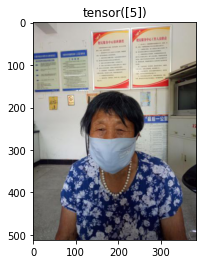

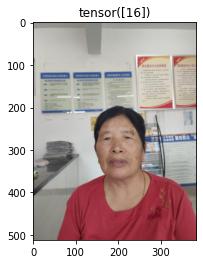

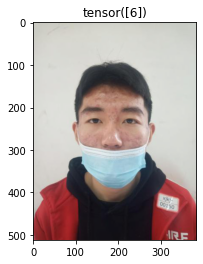

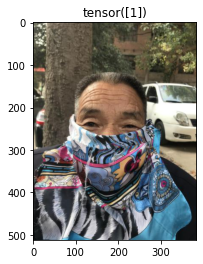

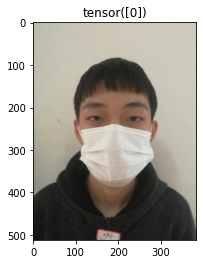

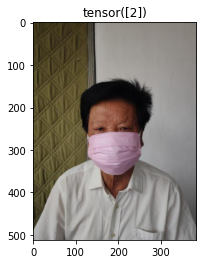

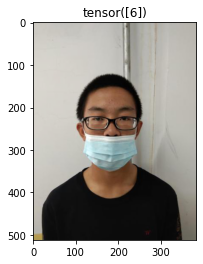

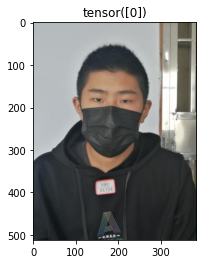

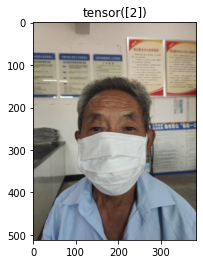

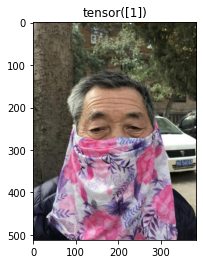

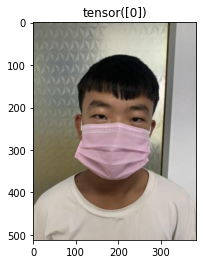

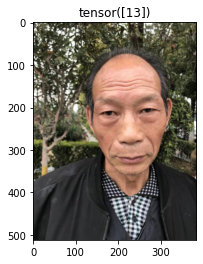

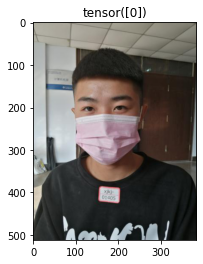

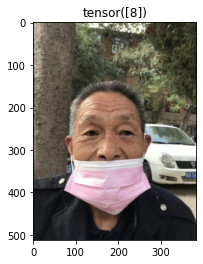

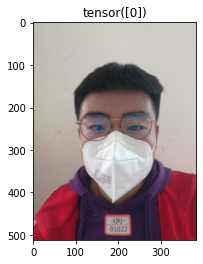

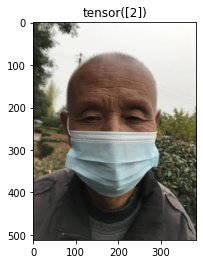

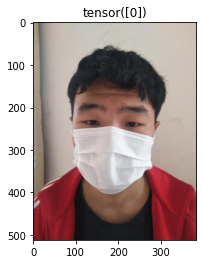

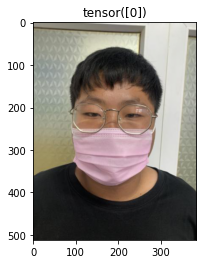

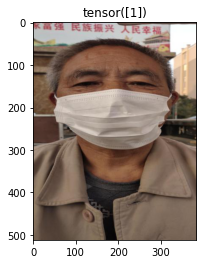

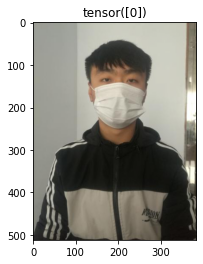

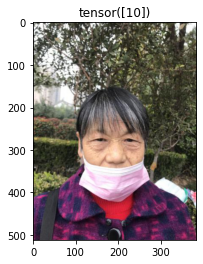

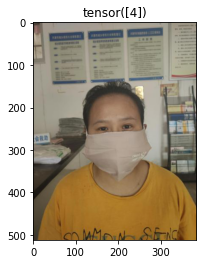

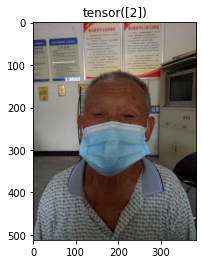

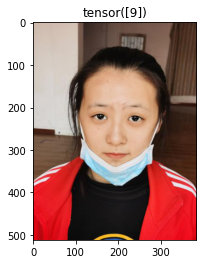

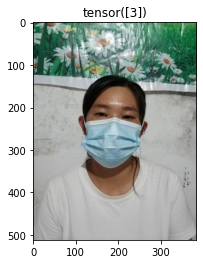

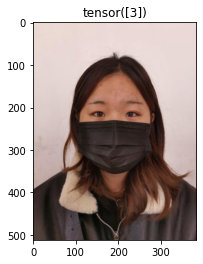

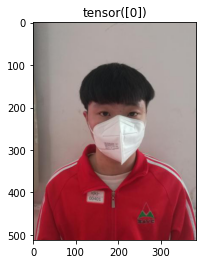

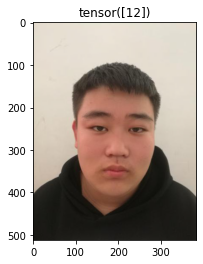

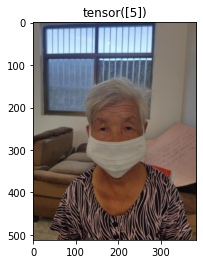

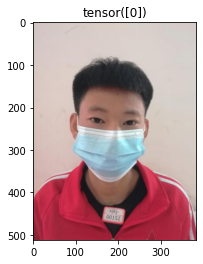

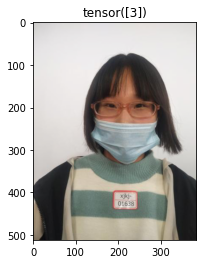

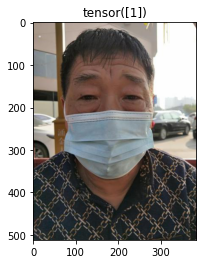

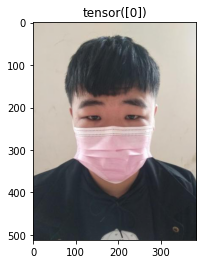

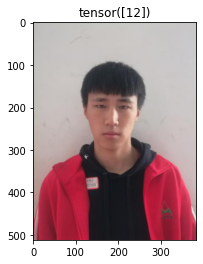

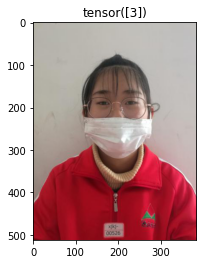

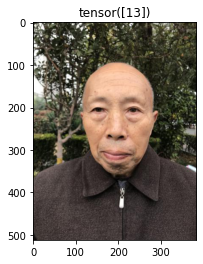

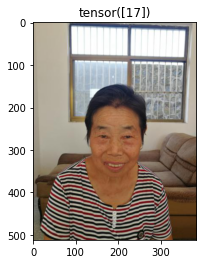

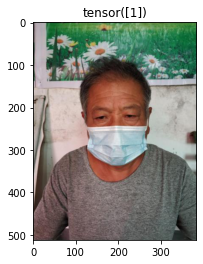

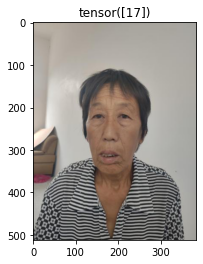

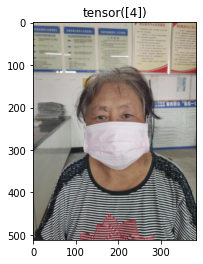

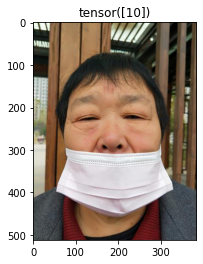

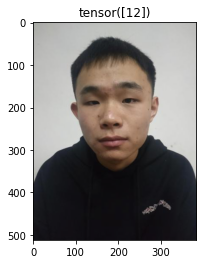

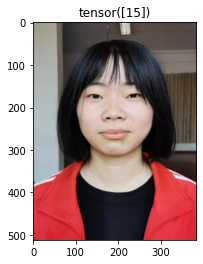

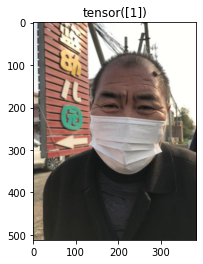

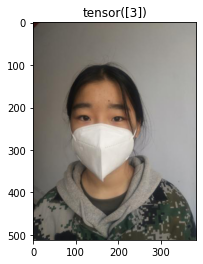

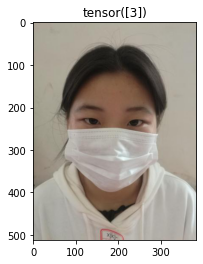

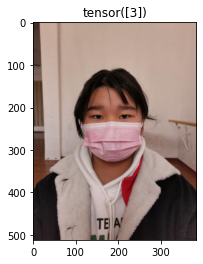

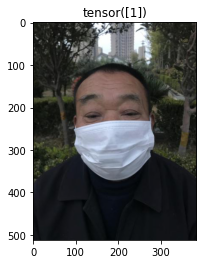

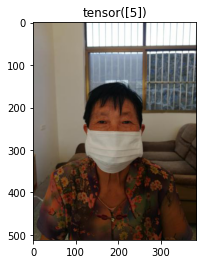

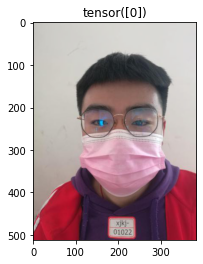

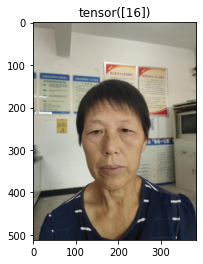

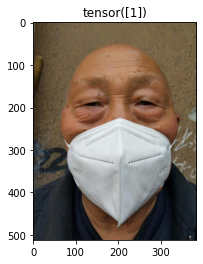

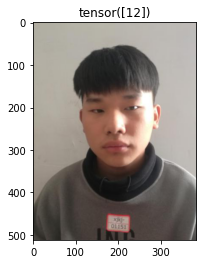

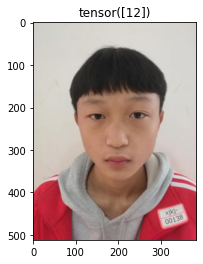

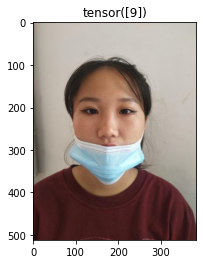

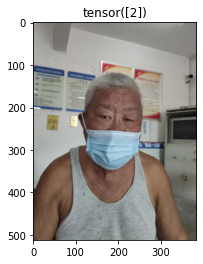

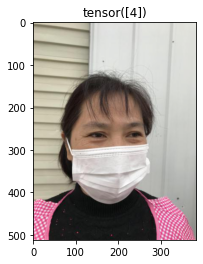

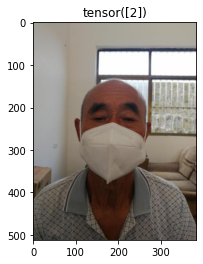

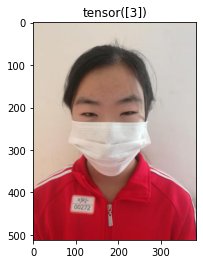

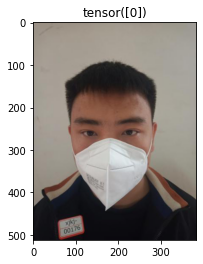

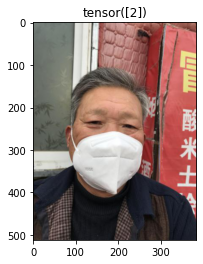

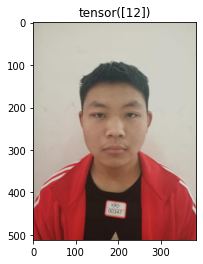

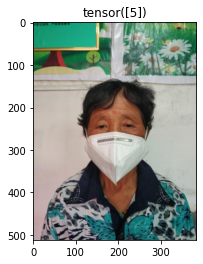

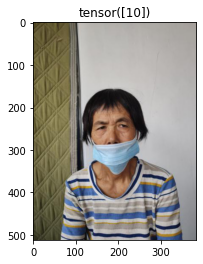

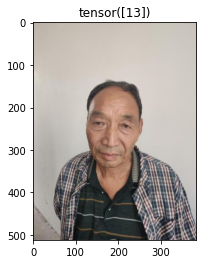

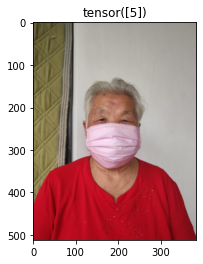

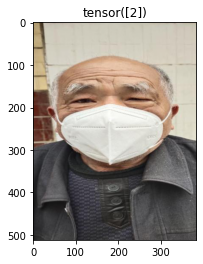

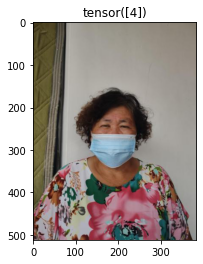

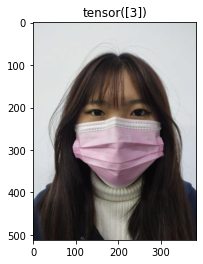

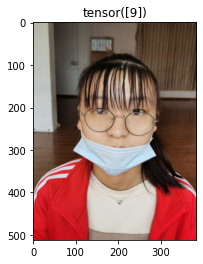

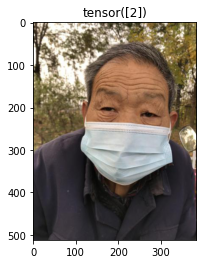

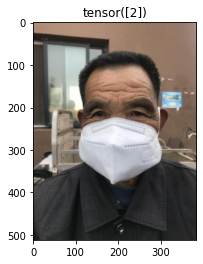

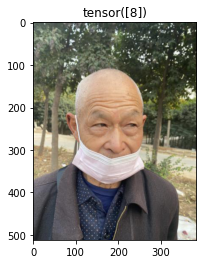

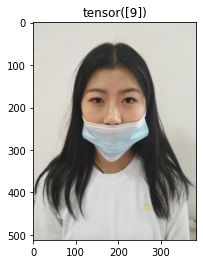

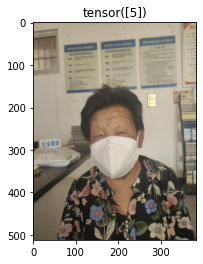

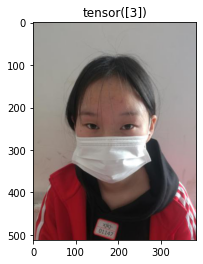

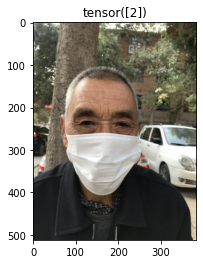

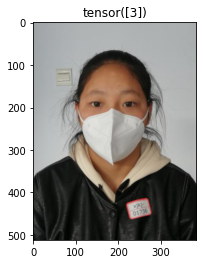

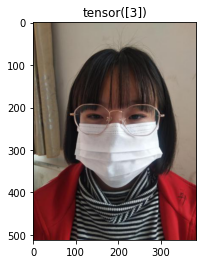

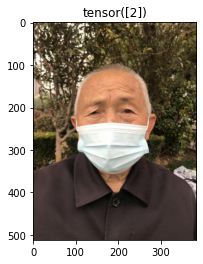

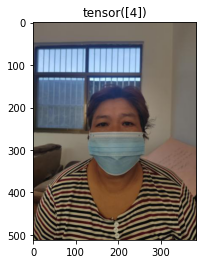

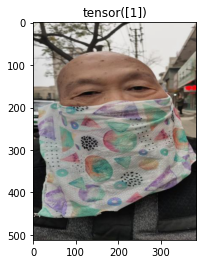

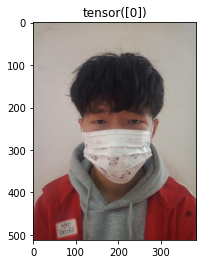

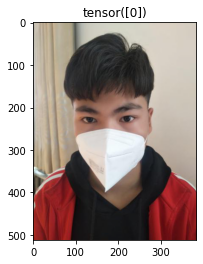

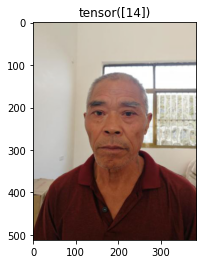

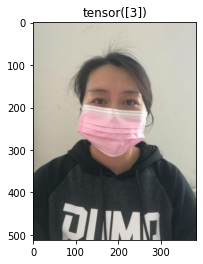

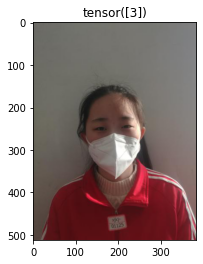

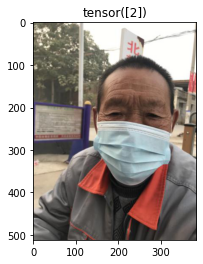

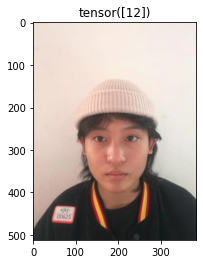

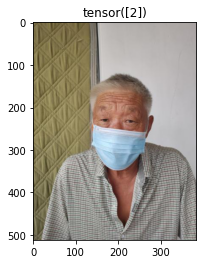

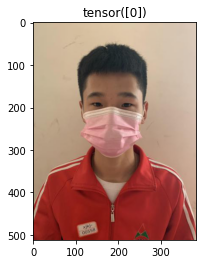

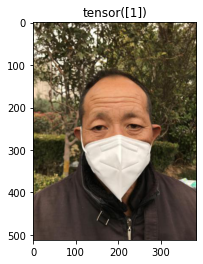

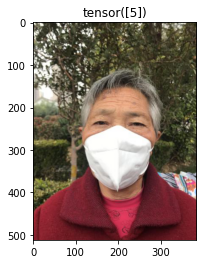

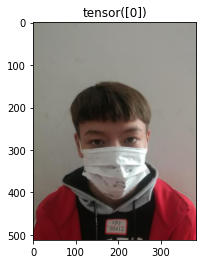

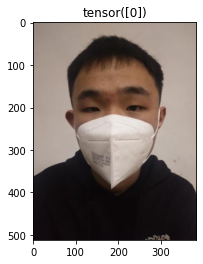

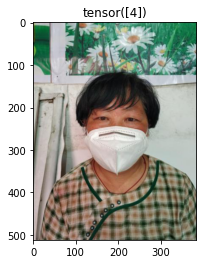

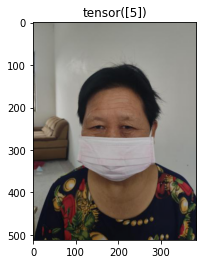

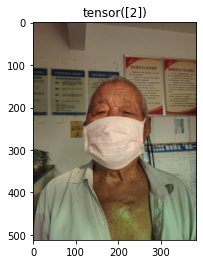

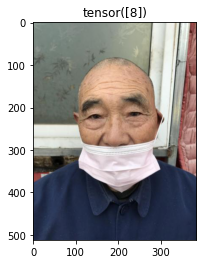

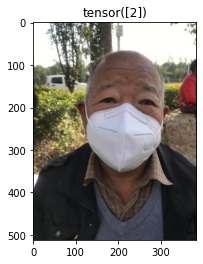

In [21]:
# Test gender model
new_model.eval()
start_time = time()

cnt = 0
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs in tqdm(loader):
        if cnt >= 300:
            inputs = inputs.to(device)

            outputs = new_model.predict(inputs)
            _, preds = torch.max(outputs, 1)

            images = torchvision.utils.make_grid(inputs)
            imshow(images.cpu(), title=preds)
        cnt += 1
            
        if cnt == 400:
            break

In [36]:
# combined model
model.eval()
all_predictions= []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = int(predicted.cpu().numpy())
        all_predictions.append(predicted)

In [38]:
# combined model
model.eval()
all_outputs= []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        all_outputs.append(outputs)

In [51]:
for i in tqdm(range(len(all_outputs))):
    all_outputs[i] = all_outputs[i].cpu().numpy()

In [56]:
output_dict = {'output': all_outputs}

output_df = pd.DataFrame(output_dict)
output_df.to_csv(os.path.join('input/data/train/csvs', 'resnet152_ensemble_outputs.csv'))

In [37]:
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
